# Position Tracking Comparison
This notebook allows interactive analysis of the data collected by the Turtlebot and Webcam.
### Importing Libraries

In [1]:
%matplotlib inline

In [2]:
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, IntSlider

### Importing Data
We define the time as variables since they are reused for the two data files.

In [3]:
year = 2020
month = 3
day = 10
robotTime = [16, 59]
webcamTime = [16, 59, 57, 143959]

In [4]:
# Import robot position data
r = pd.read_csv(
    "Turtlebot_position_log-{}-{}-{}-{}:{}.csv".format(year, month, day, *robotTime),
    header=0,
    parse_dates=[0],
    index_col =0,
    infer_datetime_format=True,
)
# sort by timestamp
r = r.sort_values(by="Timestamp")
# remove unnecessary empty column (caused by trailing comma)
r = r.drop(columns="Unnamed: 4")

# Import webcam data
w = pd.read_csv(
    "Webcam_position_log-{}-{:02d}-{:02d}T{}:{}:{}.{}.csv".format(
        year, month, day, *webcamTime
    ),
    header=0,
    parse_dates=[0],
    index_col =0,
    infer_datetime_format=True,
)
# rename theta column so it matches robot data
w = w.rename(columns={"theta(rad)": "Theta(rad)"})
w = w.sort_values(by="Timestamp")
w = w.drop(columns="Unnamed: 5")
# select just tag 42, and discard the tag ID column from here onwards
w = w[w["TagID"] == 42].drop(columns="TagID")

df = pd.concat(
    [w, r], keys=["webcam", "robot"], names=["Data Source", "Timestamp"],
)
df = df.sort_values(by="Timestamp")
df

x(m)      y(m)  Theta(rad)
Data Source Timestamp                                                       
robot       2020-03-10 16:59:29.357132+00:00  0.032879 -0.000032   -0.001227
            2020-03-10 16:59:29.368927+00:00  0.032879 -0.000032   -0.001175
            2020-03-10 16:59:29.384136+00:00  0.032879 -0.000032   -0.001248
            2020-03-10 16:59:29.429560+00:00  0.032879 -0.000032   -0.001107
            2020-03-10 16:59:29.489113+00:00  0.032879 -0.000032   -0.001224
...                                                ...       ...         ...
            2020-03-10 17:04:49.430359+00:00 -0.528596 -0.198695    0.409724
            2020-03-10 17:04:49.476599+00:00 -0.528596 -0.198695    0.409707
            2020-03-10 17:04:49.527956+00:00 -0.528596 -0.198695    0.409732
            2020-03-10 17:04:49.582799+00:00 -0.528596 -0.198695    0.409714
            2020-03-10 17:04:49.625220+00:00 -0.528596 -0.198695    0.409757

[14521 rows x 3 columns]

### Plotting the two paths
We can see here that there is a rotation & translation of the measured robot positions - but what is it? The later functions will explore this.

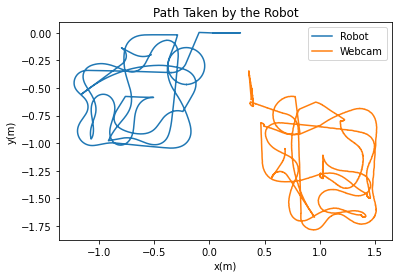

In [5]:
fig1, ax1 = plt.subplots()

ax1.plot(df.loc[("robot","x(m)")], df.loc[("robot","y(m)")],label="Robot",color="tab:blue")
ax1.plot(df.loc[("webcam","x(m)")], df.loc[("webcam","y(m)")],label="Webcam",color="tab:orange")
ax1.legend()
ax1.set_title("Path Taken by the Robot")
ax1.set_xlabel("x(m)")
ax1.set_ylabel("y(m)")
ax1.set_aspect('equal','box')
plt.show()

In [6]:
def arrow_returner(angle, length=0.1):
    dx = length * np.cos(angle)
    dy = length * np.sin(angle)
    return dx, dy

def latest_position_at_millisecond(t):
    if t < 0:
        raise KeyError("Cannot get negative time from start of range.")
    # Relative to first timestamp, t*1e6[ns] = t [ms]
    time = df.index[0][1] + pd.Timedelta(t*1e6)
    if time > df.index[-1][1]:
        raise KeyError("Requested time outside data range.")
    
    # Look for the timestamp (index) at "time", if not use last value ->"pad"
    r_i = df.loc["robot"].index.get_loc(time,method="pad")
    w_i = df.loc["webcam"].index.get_loc(time,method="pad")
    
    # Return the latest data points 
    return df.loc["robot"].iloc[r_i], df.loc["webcam"].iloc[w_i]




from IPython.display import display 

def plot_pos_at_time(t_s):
    r_d, w_d = 0,0
    fig2 =plt.figure(figsize=(5, 5), dpi= 150, facecolor='w', edgecolor='k')
    ax2 = fig2.add_subplot()
    ax2.set_title("Path Taken by the Robot")
    ax2.set_xlabel("x(m)")
    ax2.set_xlim(-2,2)
    ax2.set_ylim(-2,2)
    ax2.set_ylabel("y(m)")
    ax2.set_aspect('equal','box')
    try:
        r_d, w_d = latest_position_at_millisecond(t_s*1e3)
        ax2.arrow(r_d["x(m)"],r_d["y(m)"],*arrow_returner(r_d["Theta(rad)"]),width=0.05,color="tab:blue")
        ax2.arrow(w_d["x(m)"],w_d["y(m)"],*arrow_returner(w_d["Theta(rad)"]),width=0.05,color="tab:orange")       
    except KeyError:
        display("failed")
        pass     
    plt.show()
    

t_slider = IntSlider(min=30,max=300,step=1)


interactive(plot_pos_at_time,t_s=t_slider)





interactive(children=(IntSlider(value=30, description='t_s', max=300, min=30), Output()), _dom_classes=('widge…

In [7]:
play = widgets.Play(
    interval=200,
    value=50,
    min=30,
    max=300,
    step=1,
    description="Press play",
    disabled=False
)
widgets.jslink((play, 'value'), (t_slider, 'value'))
widgets.HBox([play, t_slider])